In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: GeForce RTX 2080 Ti


device(type='cuda')

In [3]:
max_length_smiles = 30

class Token(nn.Embedding):
    def __init__(self, vocab_size, embed_size=200, padding_idx=0):
        super().__init__(vocab_size, embed_size, padding_idx)
        
token = Token(30)

def convertToASCII(item):
    ascii = []
    for char in item:
        ascii.append(ord(char))
        
    return ascii

def convertASCIIToString(items):
    result = ""
    for item in items:
        result = result + chr(item)
    return result

In [4]:
# dataset class

class qm9Dataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None, skiprows=1, dtype='unicode')
        #print(self.data_df)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        smiles = (self.data_df.iloc[index,0] + " " * max_length_smiles)[0:max_length_smiles]
        #print("smiles", smiles)
        smiles = torch.cuda.FloatTensor(convertToASCII(smiles)) / 128.0   #ascii max value
        #smiles = smiles.reshape(-1)
        #smiles = smiles.unsqueeze(-1)
        #print("smiles.shape", smiles.shape)

        labels = []
        labels.append(float(self.data_df.iloc[index,1]))
        labels.append(float(self.data_df.iloc[index,2]))
        labels.append(float(self.data_df.iloc[index,3]))
        labels.append(float(self.data_df.iloc[index,4]))
        labels.append(float(self.data_df.iloc[index,5]))
        labels.append(float(self.data_df.iloc[index,6]))
        labels.append(float(self.data_df.iloc[index,7]))
        labels.append(float(self.data_df.iloc[index,8]))
        labels.append(float(self.data_df.iloc[index,9]))
        labels.append(float(self.data_df.iloc[index,10]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,12]))
        
        labels = torch.cuda.FloatTensor(labels)
        
        target = torch.zeros((len(self.data_df))).to(device)
        target[index] = 1.0
        
        return smiles,labels,target
    
    pass

In [5]:
qm9dataset = qm9Dataset('dataset/qm9.csv')

In [6]:
qm9dataset[2]

(tensor([0.6172, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500]),
 tensor([ 1.8511e+00,  6.3100e+00, -2.9280e-01,  6.8700e-02,  3.6150e-01,
          1.9000e+01,  2.1375e-02,  6.0020e+00, -7.6405e+01, -7.6402e+01,
         -7.6401e+01, -7.6401e+01, -7.6422e+01]),
 tensor([0., 0., 1.,  ..., 0., 0., 0.]))

In [7]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(qm9dataset,batch_size=1,shuffle=False)

'''
max_length_smiles = 0
i = 0
for smiles,label,target in data_loader:
    i += 1
    if (i % 1000 == 0):
        print(smiles)
    max_length_smiles = max(max_length_smiles, len(smiles[0]))
    #print("Max length smiles:", max_length_smiles)

    #max_length_smiles = 29
'''

'\nmax_length_smiles = 0\ni = 0\nfor smiles,label,target in data_loader:\n    i += 1\n    if (i % 1000 == 0):\n        print(smiles)\n    max_length_smiles = max(max_length_smiles, len(smiles[0]))\n    #print("Max length smiles:", max_length_smiles)\n\n    #max_length_smiles = 29\n'

In [8]:
def generate_random_smiles(size):
    random_data = torch.randint(0, 128, (1,size))/128
    return random_data.float()

def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)
    
generate_random_smiles(max_length_smiles)    

tensor([[0.2031, 0.8828, 0.1953, 0.5703, 0.1016, 0.7578, 0.0547, 0.7109, 0.5078,
         0.9141, 0.3672, 0.7969, 0.4297, 0.4531, 0.5547, 0.7344, 0.7422, 0.9922,
         0.7344, 0.5312, 0.7578, 0.9297, 0.5859, 0.9375, 0.1484, 0.5781, 0.5938,
         0.1328, 0.8047, 0.2344]])

In [9]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(max_length_smiles),
            
            nn.Linear(max_length_smiles, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # combine seed and label
        #inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        #print("outputs", outputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [10]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label,target in data_loader:
    # real
    #print("smiles.shape", smiles.shape)
    D.train(smiles, torch.cuda.FloatTensor([1.0]))
    # fake
    D.train(generate_random_smiles(max_length_smiles), torch.cuda.FloatTensor([0.0]))
    pass


counter =  10000


KeyboardInterrupt: 

In [11]:
for i in range(4):
    #random.randint(0,20000)
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    print( D.forward( data_tensor ).item() )
    pass

for i in range(4):
    print( D.forward(generate_random_smiles(max_length_smiles)).item() )
    pass

0.9950205087661743
0.9978402853012085
0.9958603978157043
0.9984051585197449
0.015979452058672905
0.03709333762526512
0.07317587733268738
0.025167221203446388


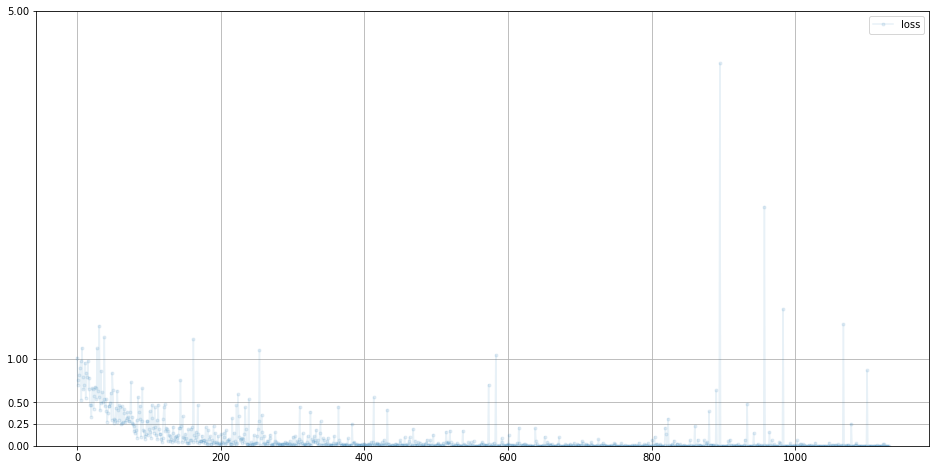

In [12]:
D.plot_progress()

In [13]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(max_length_smiles, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, max_length_smiles),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [14]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(max_length_smiles))

print("output", output)


output tensor([0.2510, 0.5044, 0.3615, 0.3908, 0.4089, 0.6190, 0.5652, 0.6113, 0.3282,
        0.4643, 0.4039, 0.3932, 0.6581, 0.6713, 0.2864, 0.5059, 0.2733, 0.5973,
        0.3276, 0.6147, 0.6845, 0.3409, 0.5060, 0.3883, 0.8239, 0.6013, 0.6935,
        0.6412, 0.4963, 0.6868], grad_fn=<SigmoidBackward>)


In [ ]:
%%time 
D = Discriminator()
D.to(device)

G = Generator()
G.to(device)


epochs = 15

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        # train discriminator on true
        D.train(smiles, torch.cuda.FloatTensor([1.0]))

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(max_length_smiles)).detach(), torch.cuda.FloatTensor([0.0]))
        # train generator
        G.train(D, generate_random_seed(max_length_smiles), torch.cuda.FloatTensor([1.0]))

    pass
    
pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
epoch =  2
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000
epoch =  3
counter =  540000
coun

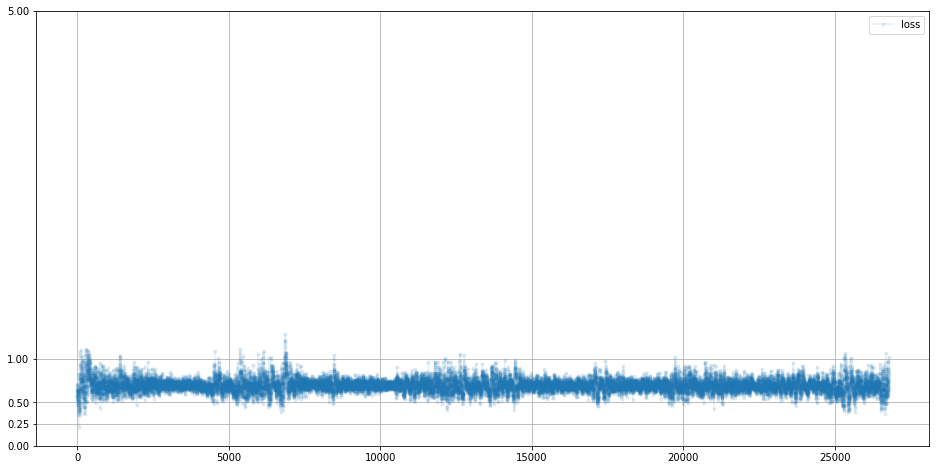

In [29]:
D.plot_progress()

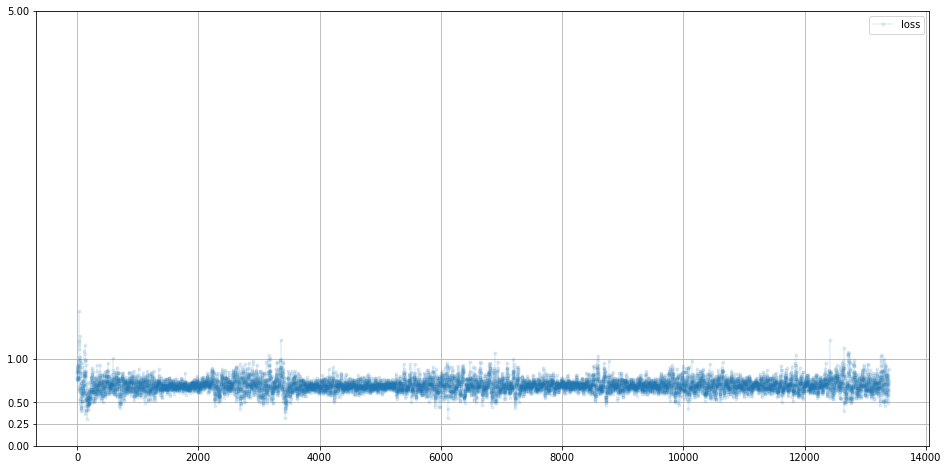

In [30]:
G.plot_progress()

In [32]:
for i in range(10):
    output = G.forward(generate_random_seed(max_length_smiles))
    smiles = output.detach().cpu().numpy() * 128
    print("smiles:", smiles.astype(int) )           
    print(convertASCIIToString(smiles))
    pass

for i in range(10):
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    #print(D_model.forward(data_tensor).item())
    print(D.forward( data_tensor ).item() )

smiles: [60 54 46 54 46 60 51 68 62 57 71 97 60 78 48 64 57 54 31 49 39 48 25 46
 46 36 42 41 35 30]
<6.6.<3D>9Ga<N0@961'0..$*)#
smiles: [75 45 43 33 74 56 30 88 74 28 92 77 47 82 53 37 75 54 28 53 42 34 15 47
 59 41 36 36 44 32]
K-+!J8XJ\M/R5%K65*"/;)$$, 
smiles: [63 46 36 38 57 32 51 51 47 45 53 98 69 79 51 68 66 38 27 32 35 39 28 43
 40 26 54 22 26 27]
?.$&9 33/-5bEO3DB& #'+(6
smiles: [ 54  74  38  56  13  63  28  75  34 103  30 114  67  73  63  46  53  78
  31  25  22  26  36  58  46  21  69  38  42  47]
?K"grCI?.5N$:.E&*/
smiles: [72 48 52 35 65 39 64 56 59 35 77 83 61 83 46 71 64 46 25 34 35 52 19 45
 54 35 30 35 31 27]
H04#A'@8;#MS=S.G@."#4-6##
smiles: [72 43 64 36 72 39 63 65 64 31 83 89 54 85 43 77 75 46 29 42 31 50 26 48
 53 38 33 34 39 26]
H+@$H'?A@SY6U+MK.*205&!"'
